In [1]:
import sys, os, imp
import numpy as np
import matplotlib.pyplot as plt
import scipy as sp

lumapiFile = "C:\\Program Files\\Lumerical\\v221\\api\\python\\lumapi.py"
lumapi = imp.load_source("lumapi", lumapiFile)
fdtdAPI = lumapi.FDTD(hide = False)

C:\Users\alves\AppData\Local\Temp\ipykernel_25792\875174513.py:1: DeprecationWarning: the imp module is deprecated in favour of importlib and slated for removal in Python 3.12; see the module's documentation for alternative uses
  import sys, os, imp


In [2]:
# units
um = 1e-6
nm = 1e-9

# Materials 
sub_material = 'SiO2 (Glass) - Palik'
core_material = 'Si (Silicon) - Palik'
core_index = 3.47
sub_index = 1.44

# Waveguide parameters
wvg_width = 500 * nm
wvg_height = 220 * nm
L_box = 2 * um
L_rect = 3 * um
space = 0.2 * um

# Bandwidth operation
option = 3
# C Band simulation: 1520 - 1575 nm (1)
# L Band simulation: 1555 - 1635 nm (2)
# Article Band:      1500 - 1580 nm (3)
if option == 1:
    wvlngth_start = 1.520 * um
    wvlngth_stop = 1.575 * um
elif option == 2:
    wvlngth_start = 1.555 * um
    wvlngth_stop = 1.635 * um
else:
    wvlngth_start = 1.500 * um
    wvlngth_stop = 1.580 * um


filename = "splitter_base.lsf" 

CONFIGURATION FILE {'root': 'C:\\Users\\alves\\AppData\\Local\\Packages\\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\\LocalCache\\local-packages\\Python311\\site-packages', 'lumapi': ''}
Accurate interface detection enabled


C:\Users\alves\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\lumopt\utilities\plotter.py:62: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  self.fig.show()


Running scipy optimizer
bounds = [[0.2 0.8]
 [0.2 0.8]
 [0.2 0.8]
 [0.2 0.8]
 [0.2 0.8]
 [0.2 0.8]
 [0.2 0.8]
 [0.2 0.8]
 [0.2 0.8]
 [0.2 0.8]
 [0.2 0.8]
 [0.2 0.8]
 [0.2 0.8]]
start = [0.25       0.27916667 0.30833333 0.3375     0.36666667 0.39583333
 0.425      0.45416667 0.48333333 0.5125     0.54166667 0.57083333
 0.6       ]
Making forward solve
Making adjoint solve
Running solves
Processing forward solve
FOM = 0.5843062375115424
Processing adjoint solve
Calculating gradients
Getting d eps: dx = 1e-09
.............
Saved frame
Making forward solve
Making adjoint solve
Running solves
Processing forward solve
FOM = 0.27165552426268624
Processing adjoint solve
Calculating gradients
Getting d eps: dx = 1e-09
.............
Making forward solve
Making adjoint solve
Running solves
Processing forward solve
FOM = 0.8901654366422448
Processing adjoint solve
Calculating gradients
Getting d eps: dx = 1e-09
.............
Saved frame
Making forward solve
Making adjoint solve
Running solves
Proc

UserWarning: FDTD simulation did not complete successfully: status 0.0

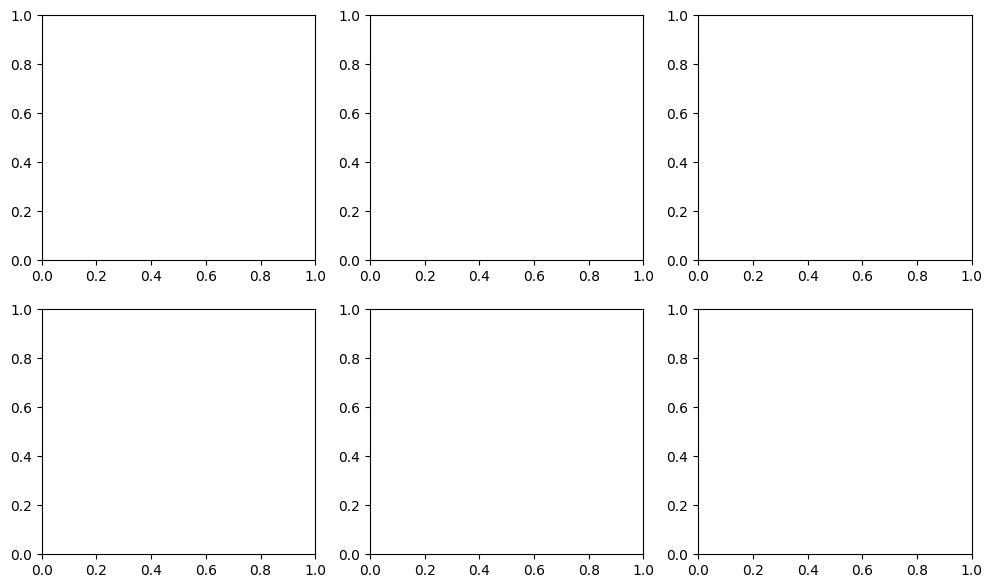

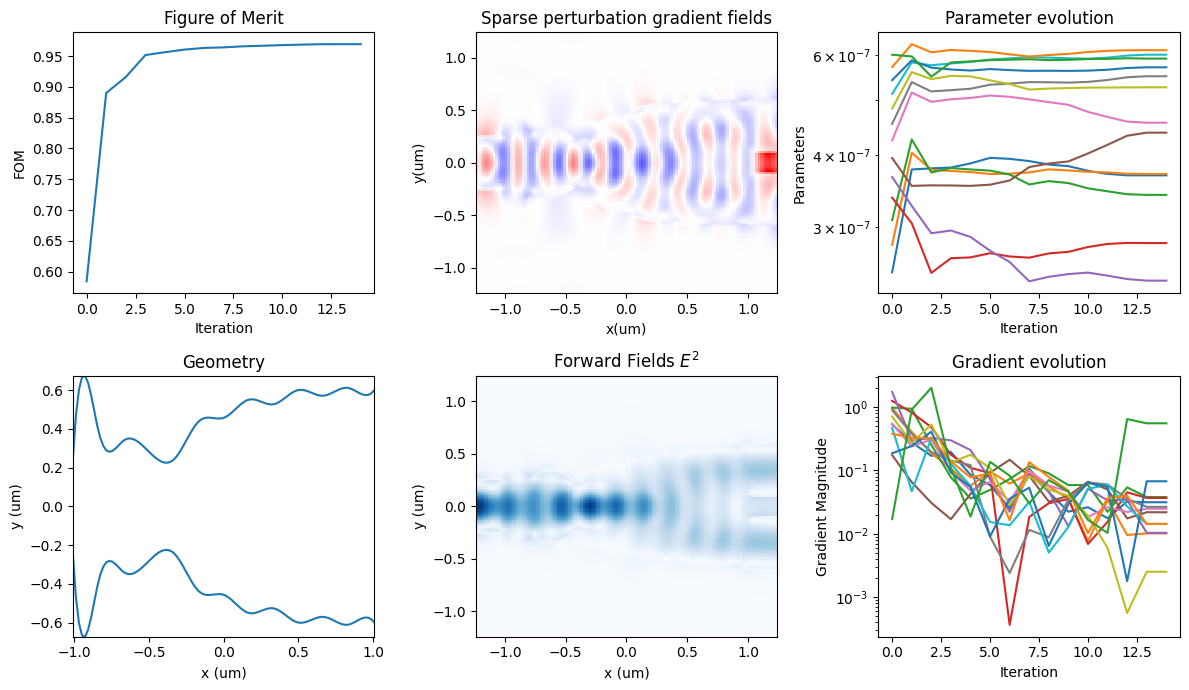

In [3]:
from lumopt.utilities.wavelengths import Wavelengths
from lumopt.geometries.polygon import FunctionDefinedPolygon
from lumopt.figures_of_merit.modematch import ModeMatch
from lumopt.optimizers.generic_optimizers import ScipyOptimizers
from lumopt.optimization import Optimization
from lumopt.utilities.plotter import Plotter

# Base file
base_script = os.path.join(os.getcwd(), 'splitter_base_TE_modematch.lsf')

wavelengths = Wavelengths(start = wvlngth_start, stop = wvlngth_stop, points = 21)

initial_points_x = np.linspace(-L_box/2, L_box/2, 13)
initial_points_y = np.linspace(wvg_width/2, wvg_width + space/2, initial_points_x.size)

def taper_splitter(params = initial_points_y):
    ''' Defines a taper where the paramaters are the y coordinates of the nodes of a cubic spline. '''
    points_x = np.concatenate(([initial_points_x.min() - 0.01e-6], initial_points_x, [initial_points_x.max() + 0.01e-6]))
    points_y = np.concatenate(([initial_points_y.min()], params, [initial_points_y.max()]))
    n_interpolation_points = 100
    polygon_points_x = np.linspace(min(points_x), max(points_x), n_interpolation_points)
    interpolator = sp.interpolate.interp1d(points_x, points_y, kind = 'cubic')
    polygon_points_y = interpolator(polygon_points_x)
    polygon_points_up = [(x, y) for x, y in zip(polygon_points_x, polygon_points_y)]
    polygon_points_down = [(x, -y) for x, y in zip(polygon_points_x, polygon_points_y)]
    polygon_points = np.array(polygon_points_up[::-1] + polygon_points_down)
    return polygon_points

# The geometry will pass on the bounds and initial parameters to the optimizer.
bounds = [(0.2e-6, 0.8e-6)] * initial_points_y.size
# The permittivity of the material making the optimizable geometry and the permittivity of the material surrounding 
# it must be defined. Since this is a 2D simulation, the depth has no importance. The edge precision defines the
# discretization of the edges forming the optimizable polygon. It should be set such there are at least a few points 
# per mesh cell. An effective index of 2.8 is user to simulate a 2D slab of 220 nm thickness.
geometry = FunctionDefinedPolygon(func = taper_splitter, initial_params = initial_points_y, bounds = bounds, z = 0.0, depth = 220e-9, eps_out = sub_index ** 2, eps_in = core_index ** 2, edge_precision = 5, dx = 1e-9)

######## DEFINE FIGURE OF MERIT ########
# The base simulation script defines a field monitor named 'fom' at the point where we want to modematch to the 3rd mode (fundamental TE mode).
fom = ModeMatch(monitor_name = 'fom', mode_number = 2, direction = 'Forward', multi_freq_src = True, target_T_fwd = lambda wl: np.ones(wl.size), norm_p = 1)

######## DEFINE OPTIMIZATION ALGORITHM ########
# This will run Scipy's implementation of the L-BFGS-B algoithm for at least 40 iterations. Since the variables are on the
# order of 1e-6, thery are scale up to be on the order of 1.
optimizer = ScipyOptimizers(max_iter = 30, method = 'L-BFGS-B', scaling_factor = 1e6, pgtol = 1e-5)

######## PUT EVERYTHING TOGETHER ########
opt = Optimization(base_script = base_script, wavelengths = wavelengths, fom = fom, geometry = geometry, optimizer = optimizer, hide_fdtd_cad = False, use_deps = True)

plot = Plotter(movie=False, plot_history=True, plot_fields=True)

######## RUN THE OPTIMIZER ########
opt.run()
